# Tomato Disease Classification Using CNN

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2025-07-26 05:45:23.823775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753508724.197376      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753508724.315440      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

The tomato dataset is from https://www.kaggle.com/datasets/arjuntejaswi/plant-village

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3       # RGB

In [3]:
datasets = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/tomato-disease-dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16012 files belonging to 10 classes.


I0000 00:00:1753508753.912134      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753508753.912991      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
class_names = datasets.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
# Inspect the shape of the data
for image_batch, labels_batch in datasets.take(1):
  print('Shape of one image batch:', image_batch.shape)
  print("Value of one labels batch:", labels_batch.numpy())

Shape of one image batch: (32, 256, 256, 3)
Value of one labels batch: [0 2 5 9 1 7 2 9 3 9 5 2 7 2 9 5 4 4 7 5 2 2 5 7 2 7 7 5 0 2 4 2]


## Visualize some of the images from the dataset

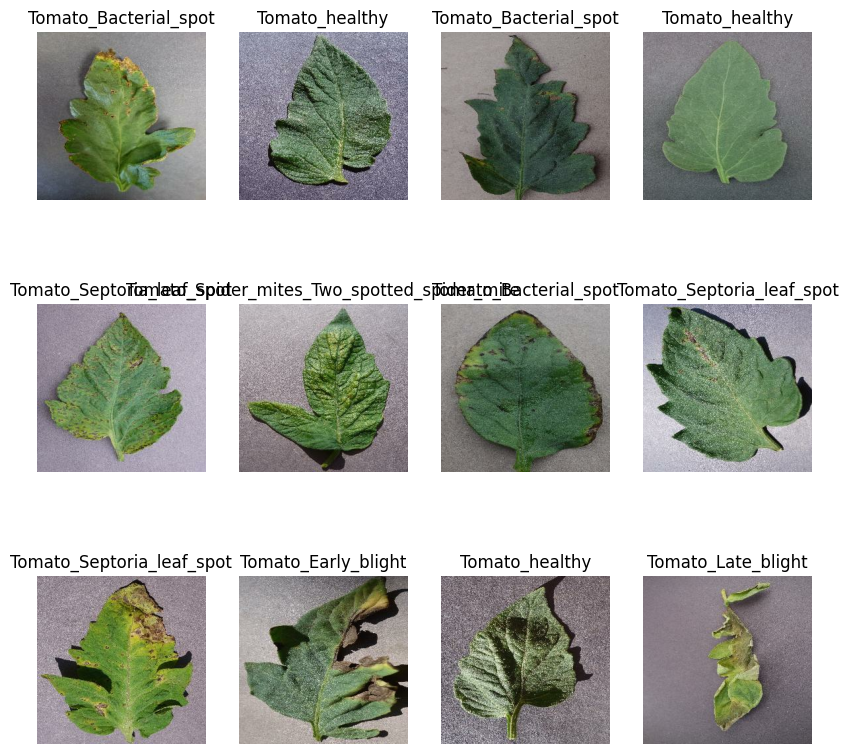

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in datasets.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Split The Dataset

I'll use 80% for training data, 10% for validation, and 10% for test data.

In [7]:
len(datasets)

501

In [8]:
# train dataset
train_size = 0.8
len(datasets)*train_size

400.8

I will take 400 data for the train dataset.

In [9]:
# test and val dataset
test_ds = datasets.skip(400)
len(test_ds)

101

In [10]:
# validation dataset
val_size = 0.1
len(datasets)*val_size

50.1

I will take 50 data for validation dataset. Therefore, we will take 51 data for test dataset.

In [11]:
# Create train, test, validation split

def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  assert (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split *ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [12]:
# split the dataset

train_ds, val_ds, test_ds = get_dataset_partitions_tf(datasets)

print(f"Length of train dataset: {len(train_ds)}")
print(f"Length of validation dataset: {len(val_ds)}")
print(f"Length of test dataset: {len(test_ds)}")

Length of train dataset: 400
Length of validation dataset: 50
Length of test dataset: 51


# Preprocessing dataset

- resizing and rescaling
- data augmentation

In [13]:
# resizing and rescaling

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [14]:
# data augmentation

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Model Building using CNN

In [15]:
n_classes = 10

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale,
    data_augmentation,

    # convolution and pooling
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # flattened
    layers.Flatten(),

    # neural network layers
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,778 (3.42 MB)

 Trainable params: 896,778 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20


I0000 00:00:1753508797.462839     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


400/400 ━━━━━━━━━━━━━━━━━━━━ 73s 78ms/step - accuracy: 0.3928 - loss: 1.7200 - val_accuracy: 0.6375 - val_loss: 1.0841
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.7212 - loss: 0.7913 - val_accuracy: 0.6069 - val_loss: 1.5537
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.8001 - loss: 0.5739 - val_accuracy: 0.5838 - val_loss: 1.6004
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.8466 - loss: 0.4445 - val_accuracy: 0.6690 - val_loss: 1.2841
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.8610 - loss: 0.3952 - val_accuracy: 0.7844 - val_loss: 0.7248
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.8786 - loss: 0.3510 - val_accuracy: 0.6994 - val_loss: 0.9523
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.8829 - loss: 0.3286 - val_accuracy: 0.6938 - val_loss: 0.9734
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.8937 - loss: 0.3010 - val_accurac

In [19]:
scores = model.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8864 - loss: 0.3518


We get 92.76% accuracy and 21,1% loss for the test dataset.

## Plot the Accuracy and Loss Curves

In [20]:
# check the parameters oh hisory

history.params

{'verbose': 1, 'epochs': 20, 'steps': 400}

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [22]:
# plot the history diagram

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

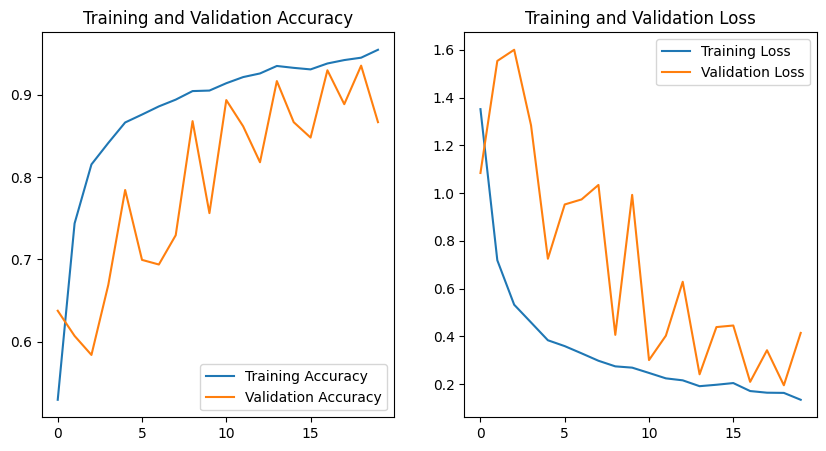

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(20), acc, label = 'Training Accuracy')
plt.plot(range(20), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(20), loss, label = 'Training Loss')
plt.plot(range(20), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Save Model

In [24]:
model.save('model.keras')
